<a href="https://colab.research.google.com/github/HareeshVutla/Deeplearning/blob/main/Image_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

Download the flowers dataset

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


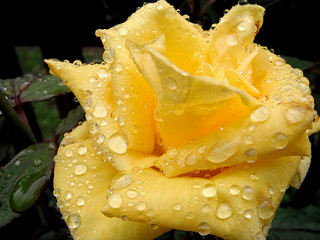

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))


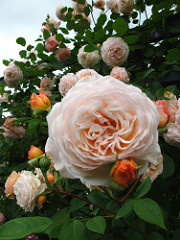

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

# **Load data using Keras utility**

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# **Visualize the data**

In [13]:
import matplotlib.pyplot as plt

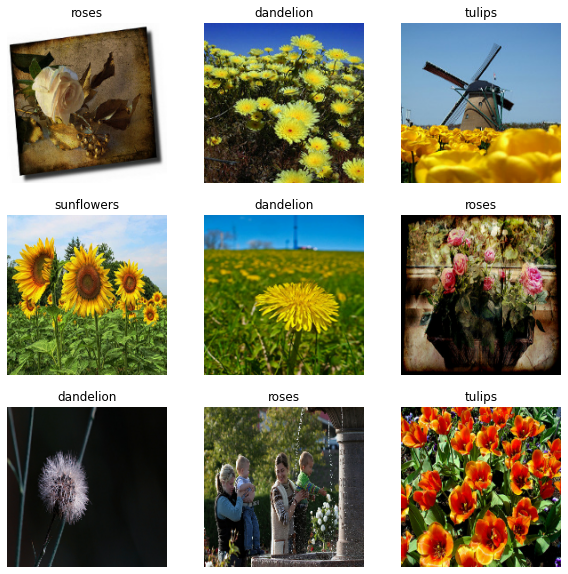

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# **Standardize the data**

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [20]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
print("image size:",first_image.shape)
print("classes/labels size: ",labels_batch.shape)

0.0 1.0
image size: (180, 180, 3)
classes/labels size:  (32,)


In [21]:
AUTOTUNE = tf.data.AUTOTUNE


# **Configure the dataset**

# **.cache():**
keeps the images in memory after they're loaded off disk during the first epoch.

This will ensure the dataset does not become a bottleneck while training your model

# **.Prefetch():**
overlaps data preprocessing and model execution while training.

In [22]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Model Training**

In [23]:
num_classes = 5
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [24]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [25]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
92/92 [==============================] - 110s 1s/step - loss: 1.3964 - accuracy: 0.3750 - val_loss: 1.1136 - val_accuracy: 0.5286
Epoch 2/5
92/92 [==============================] - 104s 1s/step - loss: 1.0619 - accuracy: 0.5644 - val_loss: 1.0037 - val_accuracy: 0.5777
Epoch 3/5
92/92 [==============================] - 104s 1s/step - loss: 0.9120 - accuracy: 0.6434 - val_loss: 0.9271 - val_accuracy: 0.6308
Epoch 4/5
92/92 [==============================] - 105s 1s/step - loss: 0.7531 - accuracy: 0.7163 - val_loss: 0.9250 - val_accuracy: 0.6444
Epoch 5/5
92/92 [==============================] - 120s 1s/step - loss: 0.5979 - accuracy: 0.7769 - val_loss: 1.0272 - val_accuracy: 0.6144


# **Manual Input Data pipelines using tf.data**

In [32]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/tulips/16506668270_b823935dc3.jpg'
b'/root/.keras/datasets/flower_photos/daisy/11023214096_b5b39fab08.jpg'
b'/root/.keras/datasets/flower_photos/roses/6105809987_8f3d7a8d67_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/3761310831_41b5eba622_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/3704306975_75b74497d8.jpg'


In [33]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)


['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [36]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print("Training data samples:",tf.data.experimental.cardinality(train_ds).numpy())
print("Validation data samples:",tf.data.experimental.cardinality(val_ds).numpy())

Training data samples: 2936
Validation data samples: 734


a short function that converts a file path to an (img, label) pair:

In [37]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [38]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [39]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [40]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [41]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


In [42]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

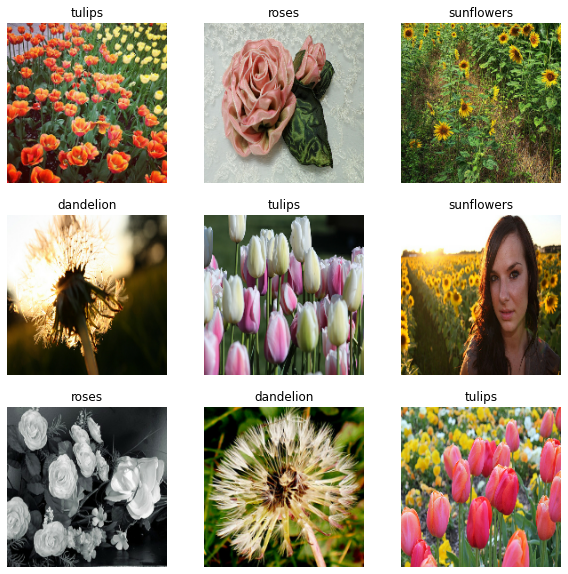

In [43]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [44]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 120s 1s/step - loss: 0.5607 - accuracy: 0.7973 - val_loss: 0.5971 - val_accuracy: 0.7834
Epoch 2/3
92/92 [==============================] - 138s 1s/step - loss: 0.3550 - accuracy: 0.8747 - val_loss: 0.7647 - val_accuracy: 0.7275
Epoch 3/3
92/92 [==============================] - 110s 1s/step - loss: 0.2339 - accuracy: 0.9230 - val_loss: 0.7320 - val_accuracy: 0.7602
